In [ ]:
# Nama : JIRYAN FAROKHI
# Email : jiryanfarokhi@gmail.com
# Domisili : Surabaya

In [ ]:
!pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import zipfile
import matplotlib.pyplot as plt

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d htagholdings/property-sales

  0% 0.00/162k [00:00<?, ?B/s]
100% 162k/162k [00:00<00:00, 71.5MB/s]


In [ ]:
zip_file = zipfile.ZipFile('/content/property-sales.zip', 'r')
zip_file.extractall('/tmp/')

In [ ]:
df = pd.read_csv("/tmp/raw_sales.csv")

In [ ]:
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [ ]:
n = len(df)
print(f"jumlah sampel : {n}")

jumlah sampel : 29580


In [ ]:
df['datesold']=pd.to_datetime(df['datesold'])

In [ ]:
uf=df[['datesold','price']]

In [ ]:
uf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datesold  29580 non-null  datetime64[ns]
 1   price     29580 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 462.3 KB


In [ ]:
pd.DataFrame(uf)

,datesold,price
0,2007-02-07,525000
1,2007-02-27,290000
2,2007-03-07,328000
3,2007-03-09,380000
4,2007-03-21,310000
...,...,...
29575,2019-07-25,500000
29576,2019-07-25,560000
29577,2019-07-26,464950
29578,2019-07-26,589000


In [ ]:
uf.dtypes

datesold    datetime64[ns]
price                int64
dtype: object

In [ ]:
uf['datesold_str'] = pd.to_datetime(uf['datesold']).dt.strftime('%Y-%m-%d')

<ipython-input-17-efe585c9380d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uf['datesold_str'] = pd.to_datetime(uf['datesold']).dt.strftime('%Y-%m-%d')


In [ ]:
uf.dtypes

datesold        datetime64[ns]
price                    int64
datesold_str            object
dtype: object

In [ ]:
X = uf['datesold_str']
y = uf['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Data Train:", len(X_train))
print("Data Test:", len(X_test))

Data Train: 23664
Data Test: 5916


In [ ]:
print(y_train.head())
print('*'*40)
print(y_train.shape)

0    525000
1    290000
2    328000
3    380000
4    310000
Name: price, dtype: int64
****************************************
(23664,)


In [ ]:
y_train.isnull().sum()

0

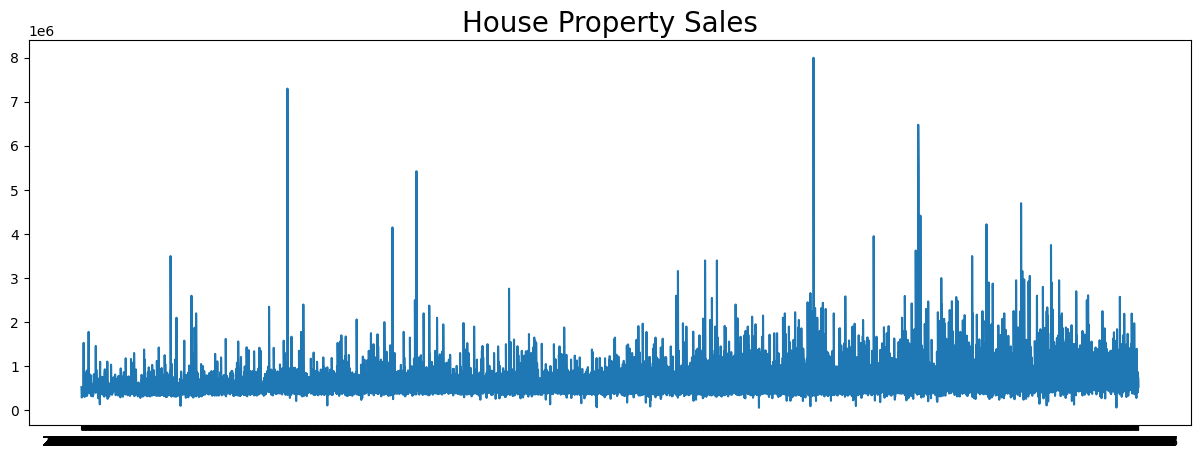

In [ ]:
dates = X_train.values
price  = y_train.values

plt.figure(figsize=(15,5))
plt.plot(dates, price)
plt.title('House Property Sales',
          fontsize=20);

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
df_scaled = y_train.to_numpy().reshape(-1, 1)
min_max_scaler = MinMaxScaler()
data = min_max_scaler.fit_transform(df_scaled)

In [ ]:
data

array([[0.05897904],
       [0.0293951 ],
       [0.03417889],
       ...,
       [0.05772015],
       [0.05897904],
       [0.08415686]])

In [ ]:
min_value = min_max_scaler.data_min_
max_value = min_max_scaler.data_max_

In [ ]:
ten_percent = (max_value - min_value) * 0.1

In [ ]:
ten_percent

array([794350.])

In [ ]:
threshold_mae = (max_value - min_value) * 10/100

In [ ]:
threshold_mae

array([794350.])

In [ ]:
train_set = windowed_dataset(data, window_size=60, batch_size=128, shuffle_buffer=10000)
window_size = 60
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
  tf.keras.layers.MaxPooling1D(pool_size=2),
  tf.keras.layers.LSTM(units=64, return_sequences=True),
  tf.keras.layers.LSTM(units=64),
  tf.keras.layers.Dense(units=30, activation='relu'),
  tf.keras.layers.Dense(units=10, activation='relu'),
  tf.keras.layers.Dense(units=1)
])


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="my_model.keras")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=5)
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/20
185/185 [==============================] - 17s 73ms/step - loss: 0.0017 - mae: 0.0466 - lr: 1.0000e-04
Epoch 2/20
185/185 [==============================] - 16s 82ms/step - loss: 0.0014 - mae: 0.0386 - lr: 1.0000e-04
Epoch 3/20
185/185 [==============================] - 15s 73ms/step - loss: 0.0011 - mae: 0.0322 - lr: 1.0000e-04
Epoch 4/20
185/185 [==============================] - 14s 68ms/step - loss: 9.8227e-04 - mae: 0.0279 - lr: 1.0000e-04
Epoch 5/20
185/185 [==============================] - 14s 71ms/step - loss: 8.7385e-04 - mae: 0.0252 - lr: 1.0000e-04
Epoch 6/20
185/185 [==============================] - 15s 73ms/step - loss: 8.0051e-04 - mae: 0.0237 - lr: 1.0000e-04
Epoch 7/20
185/185 [==============================] - 14s 69ms/step - loss: 7.5080e-04 - mae: 0.0228 - lr: 1.0000e-04
Epoch 8/20
185/185 [==============================] - 14s 69ms/step - loss: 7.1721e-04 - mae: 0.0223 - lr: 1.0000e-04
Epoch 9/20
185/185 [==============================] - 15s 75ms/step 

In [ ]:
train_loss = history.history['loss']

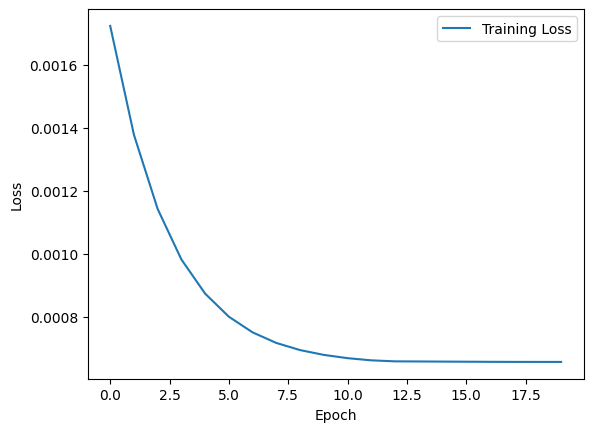

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()